<a href="https://colab.research.google.com/github/mehaase/w266-final-project/blob/main/DATASCI266_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libaries & Data

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
# Load data from Google Drive
drive.mount('/mnt/gdrive')
project_dir = "/mnt/gdrive/MyDrive/W266 Final Project"
train_df = pd.read_csv(f"{project_dir}/train_df.csv", index_col=0)
test_df = pd.read_csv(f"{project_dir}/test_df.csv", index_col=0)
train_df.head()

Mounted at /mnt/gdrive


,count,hate_speech,offensive_language,neither,class,tweet,is_hatespeech
0,3,0.000000,0.000000,1.0,2,RT AT_MENTION: How can anyone hate Charlie She...,False
2,3,0.000000,0.000000,1.0,2,RT AT_MENTION: she paid $5 to hold the monkey ...,False
3,3,1.000000,0.000000,0.0,0,RT AT_MENTION: Apartheid. &#8220;AT_MENTION: p...,True
4,3,0.666667,0.333333,0.0,0,AT_MENTION \nShe be what we say in da hood whi...,True
5,3,0.000000,1.000000,0.0,1,Get your nasty ass out of my snapchat bitch,False


# Helper Functions

In [ ]:
def plot_train_test_loss(model_history):
    # Plot training/test loss against epochs
    ymax = max(np.max(model_history.history["loss"]), np.max(model_history.history["val_loss"]))
    plt.plot(model_history.history["loss"])
    plt.plot(model_history.history["val_loss"])
    plt.title("Train/Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(0.0, ymax * 1.1)
    plt.legend(["Train", "Test"])
    plt.show()

In [ ]:
def compute_metrics(y_true, y_pred):
    p = tf.keras.metrics.Precision()
    p.update_state(y_true, y_pred)
    precision = p.result()

    r = tf.keras.metrics.Recall()
    r.update_state(y_true, y_pred)
    recall = r.result()

    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

# Training

In [ ]:
def build_cnn_model(sequence_length, embedding_dim, num_filters, kernel_sizes, dense_layer_dims, dropout_rate, vectorizer):
    cnn_input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
    cnn_embedding_layer = tf.keras.layers.Embedding(
        vectorizer.vocabulary_size(),
        embedding_dim,
        input_length=sequence_length)
    cnn_embeddings = cnn_embedding_layer(vectorizer(cnn_input_layer))

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = tf.keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = tf.keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = tf.keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)

    cnn_prediction = tf.keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = tf.keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    return cnn_model

In [ ]:
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_DIM = 256

train_X = train_df.tweet
train_Y = train_df.is_hatespeech
test_X = test_df.tweet
test_Y = test_df.is_hatespeech

vectorizer = tf.keras.layers.TextVectorization(max_tokens=10_000, output_sequence_length=MAX_SEQUENCE_LENGTH)
vectorizer.adapt(train_X)
vectorizer

In [ ]:
# Now specify model hyperparameters and call the function to create a CNN model
cnn_model = build_cnn_model(
    MAX_SEQUENCE_LENGTH,
    EMBEDDING_DIM,
    num_filters = [10, 10, 5],
    kernel_sizes = [2, 3, 5],
    dense_layer_dims = [10, 5],
    dropout_rate = 0.5,
    vectorizer=vectorizer
)

In [ ]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 128)         0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 128, 256)     1574912     ['text_vectorization[0][0]']     
                                                                                                  
 conv1d (Conv1D)                (None, 127, 10)      5130        ['embedding[0][0]']          

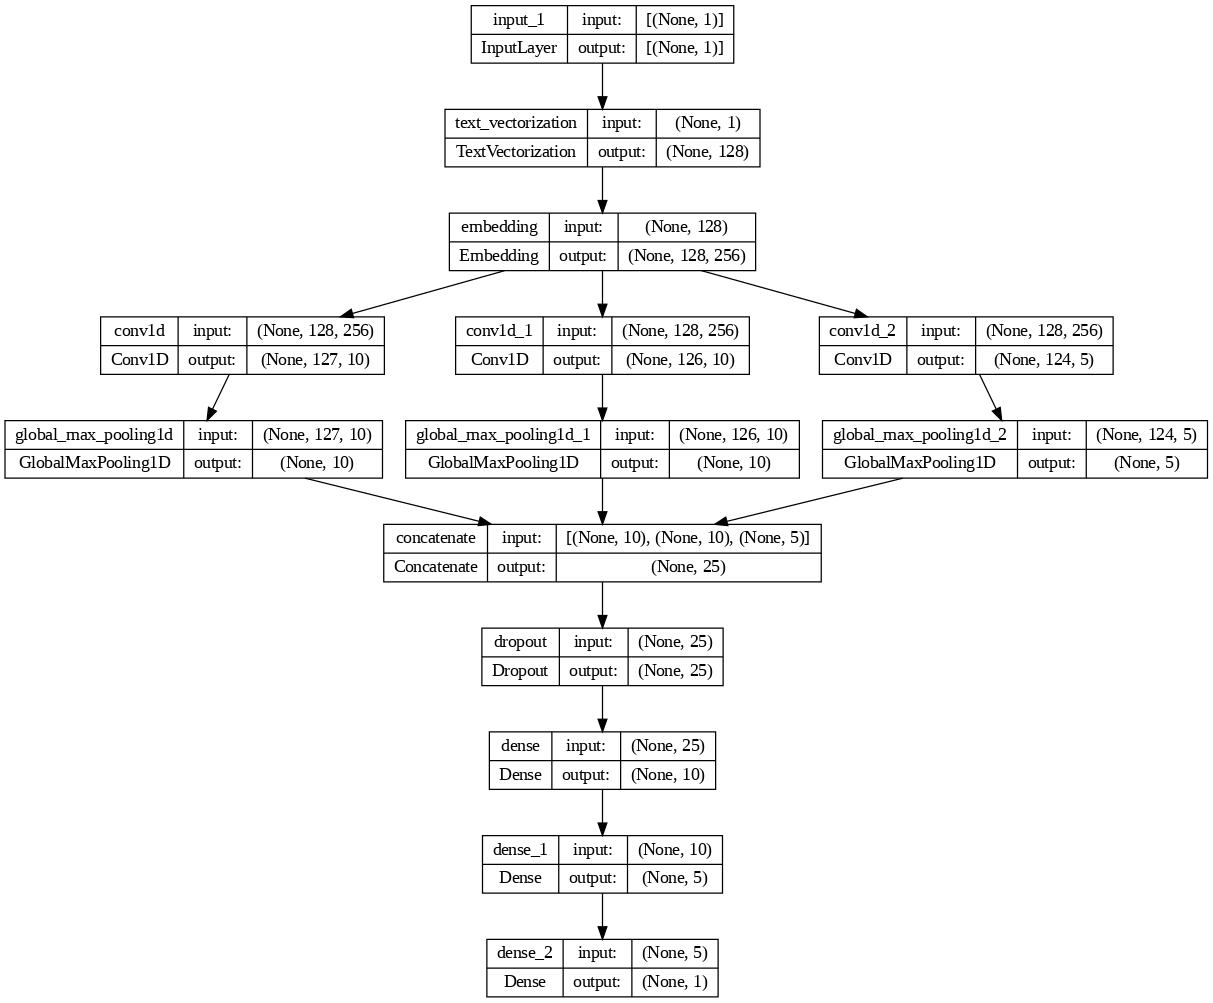

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

cnn_history = cnn_model.fit(
    train_X,
    train_Y,
    validation_data=(test_X, test_Y),
    batch_size=8,
    epochs=25,
    callbacks=[checkpoint_callback]
)

cnn_model.load_weights(checkpoint_filepath)

Epoch 1/25
286/286 [==============================] - 25s 75ms/step - loss: 0.6581 - accuracy: 0.5909 - val_loss: 0.5161 - val_accuracy: 0.7797
Epoch 2/25
286/286 [==============================] - 16s 55ms/step - loss: 0.4549 - accuracy: 0.8073 - val_loss: 0.4524 - val_accuracy: 0.7972
Epoch 3/25
286/286 [==============================] - 16s 56ms/step - loss: 0.2959 - accuracy: 0.8881 - val_loss: 0.4888 - val_accuracy: 0.7815
Epoch 4/25
286/286 [==============================] - 15s 54ms/step - loss: 0.1874 - accuracy: 0.9384 - val_loss: 0.5529 - val_accuracy: 0.7850
Epoch 5/25
286/286 [==============================] - 17s 61ms/step - loss: 0.1087 - accuracy: 0.9677 - val_loss: 0.6459 - val_accuracy: 0.7832
Epoch 6/25
286/286 [==============================] - 23s 80ms/step - loss: 0.0812 - accuracy: 0.9747 - val_loss: 0.8078 - val_accuracy: 0.7535
Epoch 7/25
286/286 [==============================] - 16s 56ms/step - loss: 0.0651 - accuracy: 0.9803 - val_loss: 0.8196 - val_accuracy:

# Evaluation

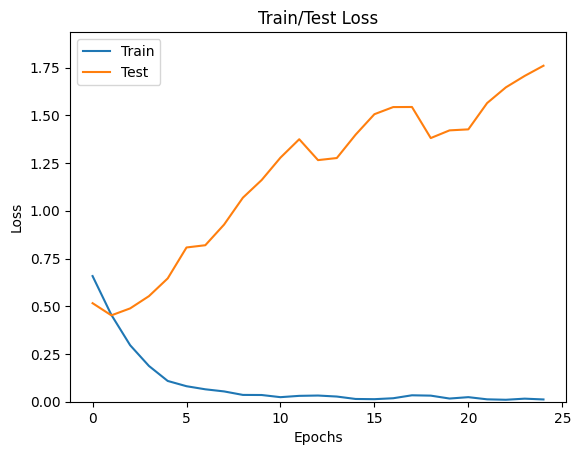

In [ ]:
plot_train_test_loss(cnn_history)

In [ ]:
pred_Y = cnn_model.predict(test_X)

18/18 [==============================] - 1s 27ms/step


In [ ]:
print("\nTest metrics:")
precision, recall, f1 = compute_metrics(test_Y, pred_Y)
print(f"Precision: {precision:0.4f}")
print(f"Recall:    {recall:0.4f}")
print(f"F1 Score:  {f1:00.4f}")


Test metrics:
Precision: 0.7867
Recall:    0.8036
F1 Score:  0.7951


# Experiment: Use Pre-trained BERT Embeddings

In [ ]:
!pip install -q -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.0 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, TFBertModel

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
bert_train_X = bert_tokenizer(
    train_X.tolist(),
    max_length=MAX_SEQUENCE_LENGTH,
    truncation=True,
    padding="max_length",
    return_tensors="tf",
)["input_ids"]
bert_test_X = bert_tokenizer(
    test_X.tolist(),
    max_length=MAX_SEQUENCE_LENGTH,
    truncation=True,
    padding="max_length",
    return_tensors="tf",
)["input_ids"]
print("train shape: ", bert_train_X.shape)
print("test shape:  ", bert_test_X.shape)

train shape:  (2288, 128)
test shape:   (572, 128)


In [ ]:
bert_embeddings = bert_model.weights[0]
bert_embeddings

<tf.Variable 'tf_bert_model_2/bert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32, numpy=
array([[-0.01018257, -0.06154883, -0.02649689, ..., -0.01985357,
        -0.03720997, -0.00975152],
       [-0.01170495, -0.06002603, -0.03233192, ..., -0.01681456,
        -0.04009988, -0.0106634 ],
       [-0.01975381, -0.06273633, -0.03262176, ..., -0.01650258,
        -0.04198876, -0.00323178],
       ...,
       [-0.02176224, -0.0556396 , -0.01346345, ..., -0.00432698,
        -0.0151355 , -0.02489496],
       [-0.04617237, -0.05647721, -0.00192082, ...,  0.01568751,
        -0.01387033, -0.00945213],
       [ 0.00145601, -0.08208051, -0.01597912, ..., -0.00811687,
        -0.04746607,  0.07527421]], dtype=float32)>

In [ ]:
def build_cnn_pt_embed_model(sequence_length, num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings):
    cnn_input_layer = tf.keras.layers.Input(shape=(sequence_length,), dtype=tf.int32)
    cnn_embedding_layer = tf.keras.layers.Embedding(
        embeddings.shape[0],
        embeddings.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embeddings),
        trainable=False,
        input_length=sequence_length)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = tf.keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = tf.keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = tf.keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)

    cnn_prediction = tf.keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = tf.keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    return cnn_model

In [ ]:
cnn_pt_bert_model = build_cnn_pt_embed_model(
    MAX_SEQUENCE_LENGTH,
    num_filters = [10, 10, 5],
    kernel_sizes = [3, 3, 5],
    dense_layer_dims = [10, 5],
    dropout_rate = 0.5,
    embeddings=bert_embeddings,
)

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

cnn_pt_bert_history = cnn_pt_bert_model.fit(
    bert_train_X,
    train_Y,
    validation_data=(bert_test_X, test_Y),
    batch_size=8,
    epochs=25,
    callbacks=[checkpoint_callback]
)

cnn_pt_bert_model.load_weights(checkpoint_filepath)

Epoch 1/25
286/286 [==============================] - 22s 69ms/step - loss: 0.6610 - accuracy: 0.5822 - val_loss: 0.5971 - val_accuracy: 0.7028
Epoch 2/25
286/286 [==============================] - 19s 65ms/step - loss: 0.5915 - accuracy: 0.7107 - val_loss: 0.5631 - val_accuracy: 0.7413
Epoch 3/25
286/286 [==============================] - 18s 65ms/step - loss: 0.5684 - accuracy: 0.7531 - val_loss: 0.5411 - val_accuracy: 0.7605
Epoch 4/25
286/286 [==============================] - 18s 62ms/step - loss: 0.5424 - accuracy: 0.7609 - val_loss: 0.5194 - val_accuracy: 0.7990
Epoch 5/25
286/286 [==============================] - 26s 90ms/step - loss: 0.5293 - accuracy: 0.7740 - val_loss: 0.5008 - val_accuracy: 0.8042
Epoch 6/25
286/286 [==============================] - 29s 103ms/step - loss: 0.5045 - accuracy: 0.7963 - val_loss: 0.4893 - val_accuracy: 0.8007
Epoch 7/25
286/286 [==============================] - 35s 122ms/step - loss: 0.4838 - accuracy: 0.7911 - val_loss: 0.5042 - val_accurac

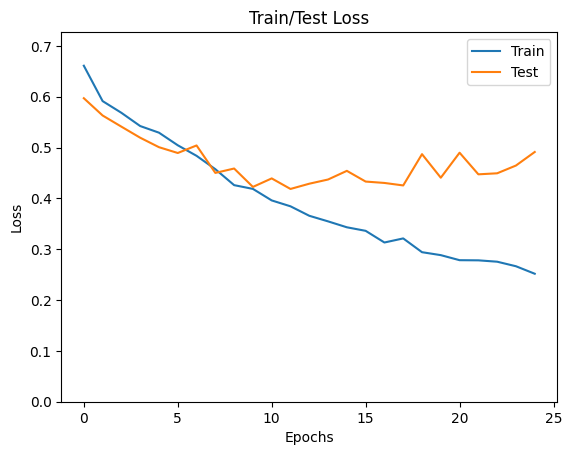

In [ ]:
plot_train_test_loss(cnn_pt_bert_history)

In [ ]:
bert_pred_Y = cnn_pt_bert_model.predict(bert_test_X)

18/18 [==============================] - 2s 76ms/step


In [ ]:
print("\nTest metrics:")
precision, recall, f1 = compute_metrics(test_Y, bert_pred_Y)
print(f"Precision: {precision:0.4f}")
print(f"Recall:    {recall:0.4f}")
print(f"F1 Score:  {f1:00.4f}")


Test metrics:
Precision: 0.8068
Recall:    0.8500
F1 Score:  0.8278
